In [1]:
import pandas as pd
from glob import glob
from collections import namedtuple, deque
import math
import itertools
import functools
from functools import reduce
from itertools import product, groupby, combinations, permutations
import numpy as np
from scipy.interpolate import UnivariateSpline
import cv2
import random
from skimage import io, morphology, img_as_bool, transform, img_as_ubyte, img_as_float, exposure, filters
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from skimage.measure import label, regionprops
from skimage.transform import probabilistic_hough_line
from scipy import stats

In [2]:
def smooth_mask(mask, smooth_sigma=2):
    density = exposure.rescale_intensity(filters.gaussian(
                                                            morphology.dilation(mask, 
                                                            footprint=morphology.disk(1)), 
                                                            sigma=smooth_sigma, 
                                                            preserve_range=False), 
                                        out_range=(0, 1))
    return density

def norm_counts(counts, weights):
    """
        This function returns a set of normalized counts, based on the weights of bins
    """
    weights = [i/ min(weights) for i in weights]
    counts_norm = [list(itertools.repeat(count, int(weight*100)))  for count, weight in zip(counts, weights)]
    return functools.reduce(lambda x1, x2 : x1+x2, counts_norm) 

def iou(mask_1, mask_2, beta=1e-3, soft=False):
    """
        This function computes a (soft) IoU of two input masks.
    """
    if soft:
        union = mask_1**2 + mask_2**2 - mask_1*mask_2
        intersection = mask_1 * mask_2
    else:
        union = np.logical_or(mask_1, mask_2)
        intersection = np.logical_and(mask_1, mask_2)
    ratio = (intersection.sum()+beta)/(union.sum()+beta)
    return ratio, union, intersection


def norm_feats(vecs):
    """
        This function normalize the features to 0-1.
    """
    vecs_1 = vecs.copy()
    for col in range(vecs_1.shape[1]):
        vecs_1[:, col] = exposure.rescale_intensity(vecs_1[:, col], out_range=(0, 1))
    return vecs_1
    

In [3]:
class CenterLine():
    def __init__(self, centerline_image=None, line_dict=None, dataframe=None, associate_image=None, image_size=None):
        self.centerline_image = img_as_float(centerline_image) if centerline_image is not None else None
        self.associate_image = img_as_float(associate_image) if associate_image is not None else None
        self.line_dict = line_dict # line_dict will always be created at initialization, line_dict > dataframe > centerlin_image
        self.linked_line_dict = None
        self.Point = namedtuple('Point', 'x y')
        self.Joint = namedtuple('Joint', 'line_ID joint_ID dir gradient')
        self.Line = namedtuple('Line', 'points head tail')
        self.Segment = namedtuple('Segment', 'point_0, point_1, length')
        if image_size is None:
            if self.centerline_image is not None:
                image_size = self.centerline_image.shape
            elif self.associate_image is not None:
                image_size = self.associate_image.shape
            else:
                image_size = (512, 512)

        if self.line_dict is not None:
            self.centerline_image = self.draw_line_dict(line_dict=self.line_dict, image_size=image_size)

        elif self.line_dict is None and self.centerline_image is not None:
            """
                Create a line_dict from the centerline_image if line_dict is not given
            """
            joints_coords, filtered_image = self.joint_filter(centerline_image) # masks have joints
            self.line_dict = self.image_to_line_dict(filtered_image)
            self.linking_fibers()
            self.line_dict = self.linked_line_dict
            self.centerline_image = self.draw_line_dict(line_dict=self.line_dict, image_size=image_size) # stored masks have joints

        elif self.line_dict is None and dataframe is not None:
            """
                Create a line_dict from the dataframe if line_dict is not given
            """
            line_dict = self.dataframe_to_lines(dataframe)
            centerline_image = self.draw_line_dict(line_dict, image_size=image_size)
            joints_coords, filtered_image = self.joint_filter(centerline_image)
            self.line_dict = self.image_to_line_dict(filtered_image)  
            self.linking_fibers()
            self.line_dict = self.linked_line_dict
            self.centerline_image = self.draw_line_dict(line_dict=self.line_dict, image_size=image_size)

        else: print("At least one of centerline_image, line_dict, and dataframe should be provided.")


    def dataframe_to_lines(self, label_csv):
        """
            This function generates a line_dict from a dataframe
        """
        line_IDs = set(label_csv.iloc[:, 0])
        line_dict = {}
        for line_ID in line_IDs:
            line_dict[str(line_ID)] = []
        for idx in range(len(label_csv)):
            line_ID = label_csv.iloc[idx, 0]
            line_coords = self.Point(label_csv.iloc[idx, 1], label_csv.iloc[idx, 2]) # x, y 
            line_dict[str(line_ID)].append(line_coords)
        for line_ID in line_IDs:
            line_dict[str(line_ID)] = self.Line(points=line_dict[str(line_ID)], head=-1, tail=-1)
        self.sort_line_dict(line_dict)
        return line_dict
        

    def image_to_line_dict(self, filtered_image):
        """
            This function takes a centerline image (joint filtered) and return a line_dict, noted that this is lossy
        """
        labeled = label(filtered_image, connectivity=2)
        regions = regionprops(labeled)
        line_dict = {}
        # return_regions = []
        for idx, region in enumerate(regions):
            if region.area<2: continue
            points = [self.Point(x=coord[1], y=coord[0]) for coord in region.coords]
            line_dict[str(idx)] = self.Line(points=points, head=-1, tail=-1)
            # return_regions.append(region)
        self.sort_line_dict(line_dict)
        return line_dict


    def joint_filter(self, image):
        """
            This function takes a centerline image (numpy array) and replace joints with 0
        """
        image = img_as_float(image)
        coords = []
        corner_tpl = np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]])
        edge_tpl = np.array([[1, 0, 1], [0, 0, 0], [0, 1, 0]])
        tr_tpl = deque([1, 0, 1, 0 ,0 ,1, 0, 0])
        tr_tpls = []
        for i in range(8):
            tr_tpl.rotate(i)
            tr_tpls.append(np.asarray(tr_tpl))

        for i in range(1, image.shape[0]-1):
            for j in range(1, image.shape[1]-1):
                kernel = image[i-1:i+2, j-1:j+2]
                ks = np.count_nonzero(kernel)
                sn_kernel = np.asarray([
                    kernel[0, 0], kernel[0, 1], kernel[0, 2], kernel[1, 2], 
                    kernel[2, 2], kernel[2, 1], kernel[2, 0], kernel[1, 0]
                ])
                if kernel[1, 1] == 1:
                    if ks==6:
                        coords.append(np.asarray([i, j]))
                    elif np.count_nonzero(kernel*corner_tpl)>=3 or np.count_nonzero(kernel*edge_tpl)>=3:
                        coords.append(np.asarray([i, j]))
                    elif max([np.count_nonzero(sn_kernel*i) for i in tr_tpls])>=3:
                        coords.append(np.asarray([i, j]))
        for coord in coords:
            image[int(coord[0]), int(coord[1])] = 0
        
        return np.vstack(coords) if len(coords)>0 else np.array([]), img_as_ubyte(image)

    def sort_points(self, input_points):
        """
            This function sorts points of a line in spatial order and returns a set of sorted points
        """
        sorted_points = []
        unsorted_points = input_points
        unsorted_points = sorted(unsorted_points, key=lambda k: [k.x, k.y])
        start_point = unsorted_points.pop(0)
        sorted_points.append(start_point)
        while len(unsorted_points) > 0:
            current_point = sorted_points[-1]
            closest_idx = min(range(len(unsorted_points)), 
                key=lambda i: (unsorted_points[i].x-current_point.x)**2+(unsorted_points[i].y-current_point.y)**2)
            sorted_points.append(unsorted_points.pop(closest_idx))
        return sorted_points

    def sort_line_dict(self, line_dict):
        """
            This function sorts points of all lines in a line_dict in-place
        """
        for k, v in line_dict.items():
            points = v.points
            sorted_points = self.sort_points(points)
            v = v._replace(points=sorted_points)
            line_dict[k] = v

    def draw_line(self, points, image, offset=(0, 0)):
        """
            This function draws a set of points that defines a centerline on a image (in-place)
        """
        points_x = [point.x-offset[0] for point in points]
        points_y = [point.y-offset[1] for point in points]
        points = np.vstack((points_x, points_y)).T.astype(np.int32)
        # Linear length along the line:
        # distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
        # distance = np.insert(distance, 0, 0)/distance[-1]
        # Build a list of the spline function, one for each dimension:
        if False: #points.shape[0] > 2:
            splines = [UnivariateSpline(distance, coords, k=1, s=.1) for coords in points.T]
            # Computed the spline for the asked distances:
            alpha = np.linspace(0, 1, 75)
            points_fitted = np.rint(np.vstack( spl(alpha) for spl in splines ).T).astype(np.int32)
        else:
            points_fitted = points
        points_fitted = points_fitted.reshape((-1, 1, 2)) 
        if len(image.shape) == 3:
            color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
            image = cv2.polylines(image, [points_fitted], isClosed=False, color=color, thickness=1)
        else:
            color = 225
            image = cv2.polylines(image, [points_fitted], isClosed=False, color=color, thickness=1)
        return image  


    def draw_line_dict(self, line_dict, image_size=(512, 512)):
        """
            This function draws a line_dict on an image
        """
        image = np.zeros((image_size[0], image_size[1]), np.uint8)
        for k, v in line_dict.items():
            points = v.points
            image = self.draw_line(points, image)
        image = morphology.dilation(image)
        image = img_as_ubyte(transform.resize(image, (image_size[0], image_size[1]), order=0, anti_aliasing=True))
        _, image = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        image = morphology.skeletonize(img_as_bool(image))
        return image


    def line_gradient(self, line, start=-1): # -1 point backwards
        """
            This function computes the outwards angle at either end of a centerline
        """
        points_angle = lambda pt_1, pt_2 : math.atan2((pt_1.y-pt_2.y), (pt_1.x-pt_2.x)) # point to first point
        points_dist = lambda pt_1, pt_2 : math.sqrt((pt_1.x-pt_2.x)**2 + (pt_1.y-pt_2.y)**2)
        if start==1:
            line = list(reversed(line))
        angle = points_angle(line[0], line[1]) # point to first point
        if len(line)>2:
            decay = points_dist(line[0], line[1])/(points_dist(line[1], line[2])+points_dist(line[0], line[1]))
            delta_x = line[1].x + decay*(line[2].x - line[1].x) + decay**2*(line[2].x - line[0].x)
            delta_y = line[1].y + decay*(line[2].y - line[1].y) + decay**2*(line[2].y - line[0].y)
            angle = points_angle(line[0], self.Point(delta_x, delta_y))
        angle = angle * 180 / math.pi
        return angle


    def connect_lines(self, line_dict):
        """
            This function connects centerlines based on their tail/head connectivities
        """
        count = 0
        line_dict_copy = line_dict.copy()
        for k in list(line_dict_copy.keys()):
            try:
                v = line_dict_copy[k]
                if int(v.head) * int(v.tail) <= 0:
                    if int(v.head)>=0:
                        v_0 = line_dict_copy[v.head]
                        if v_0.head==k:
                            line_dict_copy[v.head] = self.Line(list(reversed(v.points))+v_0.points, head=v.tail, tail=v_0.tail)
                            del line_dict_copy[k]
                        if v_0.tail==k:
                            line_dict_copy[v.head] = self.Line(v_0.points+v.points, head=v_0.head, tail=v.tail)
                            del line_dict_copy[k]
                    if int(v.tail)>=0:
                        v_0 = line_dict_copy[v.tail]
                        if v_0.head==k:
                            line_dict_copy[v.tail] = self.Line(v.points+v_0.points, head=v.head, tail=v_0.tail)
                            del line_dict_copy[k]
                        if v_0.tail==k:
                            # print(Line(v.points+list(reversed(v_0.points)), head=v.head, tail=v_0.head))
                            line_dict_copy[v.tail] = self.Line(v.points+list(reversed(v_0.points)), head=v.head, tail=v_0.head)
                            # print(line_dict_copy)
                            del line_dict_copy[k]
            except Exception as e:
                # print(e)
                pass
        return line_dict_copy 


    def linking_fibers(self, line_dict=None, joint_thresh=3, angle_thresh=60):
        """
            This function takes joins close fragments of the line_dict and return a line_dict with linked fibers. 
            Close end points with similar incident angles will be connected.
        """
        if line_dict is None:
            line_dict = self.line_dict.copy()
        else:
            line_dict = line_dict.copy()
        end_points = [[item.points[0], item.points[-1]] for key, item in line_dict.items()]
        end_points = reduce(lambda x1, x2 : x1+x2, end_points) # flatten
        close_points = lambda pt_1, pt_2, dist_thresh : math.sqrt((pt_1.x-pt_2.x)**2 + (pt_1.y-pt_2.y)**2) < dist_thresh
        
        joints = []
        while len(end_points):
            current_point = end_points.pop() # pop one element
            
            for point in end_points:
                pop_point = close_points(current_point, point, joint_thresh) # compare to the rest
                if pop_point:
                    end_points.remove(point)
                if pop_point:
                    joints.append(current_point)
        joints = list(set(joints))

        grad_list = []
        joint_IDs = []
        for idx, joint in enumerate(joints):
            for k, v in line_dict.items():
                # print(v.points)
                if close_points(v.points[0], joint, joint_thresh):
                    angle_start = self.line_gradient(v.points, -1) # backwards
                    grad_list.append(self.Joint(k, idx, -1, angle_start))
                    joint_IDs.append(idx)
                if close_points(v.points[-1], joint, joint_thresh):
                    angle_end = self.line_gradient(v.points, 1) # forwards
                    grad_list.append(self.Joint(k, idx, 1, angle_end))
                    joint_IDs.append(idx)
        joint_IDs = list(set(joint_IDs))

        joint_dict = {}
        for joint_ID in joint_IDs:
            joint_dict[str(joint_ID)] = []
        for joint_ID in joint_IDs:
            for grad in grad_list:
                if grad.joint_ID==joint_ID:
                    joint_dict[str(joint_ID)].append(grad)
        link_dict = {}
        for k, v in joint_dict.items():
            grads = [i.gradient for i in v]
            diff = [abs(abs(i[0]-i[1])-180) for i in list(product(grads, grads))]
            result = [i for i, x in enumerate(diff) if x<angle_thresh]
            result = [frozenset((i//len(grads), i%len(grads))) for i in result]
            result = set(result)
            result = [set(i) for i in result]
            if len(result) > 1:
                pair_score = [abs(abs(grads[tuple(line_pair)[0]]-grads[tuple(line_pair)[1]])-180) for line_pair in result]
                sorted_result = [x for _, x in sorted(zip(pair_score, result))]
                running_set = set()
                pruned_result = []
                for line_pair in sorted_result:
                    if len(line_pair.intersection(running_set))==0:
                        pruned_result.append(line_pair)
                        running_set = running_set.union(line_pair)

                result = [tuple(i) for i in pruned_result]
            else:
                result = [tuple(i) for i in result]
            link_dict[k] = result

        for (k_1,v_1), (k_2,v_2) in zip(link_dict.items(), joint_dict.items()):
            for i in v_1:
                line_a = v_2[i[0]]
                line_b = v_2[i[1]]
                if line_a.dir==1: # a tail
                    line_dict[line_a.line_ID] = self.Line(line_dict[line_a.line_ID].points, head=line_dict[line_a.line_ID].head, tail=line_b.line_ID) #
                if line_a.dir==-1: # a head
                    line_dict[line_a.line_ID] = self.Line(line_dict[line_a.line_ID].points, head=line_b.line_ID, tail=line_dict[line_a.line_ID].tail)
                if line_b.dir==1: # b tail
                    line_dict[line_b.line_ID] = self.Line(line_dict[line_b.line_ID].points, head=line_dict[line_b.line_ID].head, tail=line_a.line_ID)
                if line_b.dir==-1: # b head
                    line_dict[line_b.line_ID] = self.Line(line_dict[line_b.line_ID].points, head=line_a.line_ID, tail=line_dict[line_b.line_ID].tail)

        line_dict_copy = line_dict.copy()
        heads = max([int(v.head) for k, v in line_dict_copy.items()])
        tails = max([int(v.tail) for k, v in line_dict_copy.items()])
        max_attemp = 0
        while not(heads==-1 and tails==-1):
            max_attemp += 1
            line_dict_copy = self.connect_lines(line_dict_copy)
            heads = max([int(v.head) for k, v in line_dict_copy.items()])
            tails = max([int(v.tail) for k, v in line_dict_copy.items()])
            if max_attemp > 10:
                break
        self.sort_line_dict(line_dict_copy)
        self.linked_line_dict = line_dict_copy

    def compute_feats(self, image=None, smooth_sigma=2):
        """
            This function takes a centerline image (numpy array) and return centerline features and individual fragments
        """
        # compute cirvar, cirmean, lenvar, lenmean, num_segs, alignment coefficient (normalized)
        points_dist = lambda pt_0, pt_1 : math.sqrt((pt_0.x-pt_1.x)**2 + (pt_0.y-pt_1.y)**2)
        segment_angle = lambda segment : math.atan2((segment.point_1.y-segment.point_0.y), (segment.point_1.x-segment.point_0.x)) #* 180 / math.pi
        if image is None:
            image = image.copy()
        else:
            image = self.image.copy()
        lines = probabilistic_hough_line(image, threshold=1, line_length=2, line_gap=0, seed=0)
        angles = []
        lengths = []
        joints, filtered = self.joint_filter(image)
        _, regions = self.image_to_line_dict(filtered)
        line_lengths = np.asarray([region.area for region in regions if region.area>3])
        for line in lines:
            p0, p1 = line # (x1, y1), (x2, y2)
            if p0[0]<=p1[0]:
                point_0 = self.Point(p0[0], p0[1])
                point_1 = self.Point(p1[0], p1[1])
            if p0[0]>p1[0]:
                point_1 = self.Point(p0[0], p0[1])
                point_0 = self.Point(p1[0], p1[1])
            segment = self.Segment(point_0, point_1, points_dist(point_0, point_1))
            angles.append(segment_angle(segment))
            lengths.append(segment.length)
            
        density = smooth_mask(image)
        if len(lines)>0:
            angles_norm = norm_counts(angles, lengths)
            cirmean = stats.circmean(angles_norm, high=math.pi/2, low=-math.pi/2)
            cirvar = stats.circvar(angles_norm, high=math.pi/2, low=-math.pi/2)
            lenmean = np.mean(line_lengths) + joints.shape[0]/np.count_nonzero(image)
            lenvar = np.var(line_lengths/lenmean)
            intensity = np.count_nonzero(image)
            feats = {'cir_mean' : cirmean, 'cir_var' : cirvar, 'len_mean' : lenmean, 'len_var' : lenvar, 'intensity' : intensity, 'density' : density}
        else:
            feats = {'cir_mean' : 1, 'cir_var' : 1, 'len_mean' : 1, 'len_var' : 1, 'intensity' : 1, 'density' : density}
        self.feats = feats
        self.regions

    def compute_fiber_feats(self, smooth_sigma=2):
        """
            This function computes centerline features from the centerline_image
        """
        # compute cirvar, cirmean, lenvar, lenmean, num_segs, alignment coefficient (normalized)
        points_dist = lambda pt_0, pt_1 : math.sqrt((pt_0.x-pt_1.x)**2 + (pt_0.y-pt_1.y)**2)
        segment_angle = lambda segment : math.atan2((segment.point_1.y-segment.point_0.y), (segment.point_1.x-segment.point_0.x)) #* 180 / math.pi
        _, filtered_image = self.joint_filter(self.centerline_image)
        line_dict = self.image_to_line_dict(filtered_image)
        self.linking_fibers(line_dict)
        line_regions = []
        angles = []
        lengths = []
        full_lengths = []
        waviness = []
        single_segment = 0
        for k, v in line_dict.items():
            points = v.points
            # min_x = min([p.x for p in points])
            # min_y = min([p.y for p in points])
            # max_x = max([p.x for p in points])
            # max_y = max([p.y for p in points])
            image = np.zeros((512, 512), np.uint8)
            image = self.draw_line(points, image)
            # image = morphology.skeletonize(image)
            sub_regions = regionprops(label(image, connectivity=2))
            _, image = self.joint_filter(sub_regions[0].image)
            labeled = label(image, connectivity=2)
            regions = regionprops(labeled)
            line_regions.extend(regions)
        line_regions = [i for i in line_regions if i.area>=5]
        for region in line_regions:   
            fragments = probabilistic_hough_line(region.image, threshold=1, line_length=2, line_gap=0, seed=0)
            # compute waviness
            seg_angles = []
            seg_lengths = []
            for fragment in fragments:
                p0, p1 = fragment # (x1, y1), (x2, y2)
                if p0[0]<=p1[0]:
                    point_0 = self.Point(p0[0], p0[1])
                    point_1 = self.Point(p1[0], p1[1])
                if p0[0]>p1[0]:
                    point_1 = self.Point(p0[0], p0[1])
                    point_0 = self.Point(p1[0], p1[1])
                seg = self.Segment(point_0, point_1, points_dist(point_0, point_1))
                seg_angle = segment_angle(seg)
                seg_length = seg.length
                seg_angles.append(seg_angle)
                seg_lengths.append(seg_length)
                # for computing global attribute
                angles.append(seg_angle)
                lengths.append(seg_length)
            full_lengths.append(region.area)
            if len(seg_angles) > 1:
                seg_angles = norm_counts(seg_angles, seg_lengths)
                waviness.append(stats.circvar(seg_angles, high=math.pi/2, low=-math.pi/2))
            else:
                single_segment += 1
                waviness.append(0)
            
        density = smooth_mask(self.centerline_image, smooth_sigma=smooth_sigma)
        if len(waviness)>0:
            angles_norm = norm_counts(angles, lengths)
            cirmean = stats.circmean(angles_norm, high=math.pi/2, low=-math.pi/2)
            cirvar = stats.circvar(angles_norm, high=math.pi/2, low=-math.pi/2)
            lenmean = np.mean(full_lengths)
            # lenvar = np.var(exposure.rescale_intensity(np.vstack(lengths), out_range=(0, 1)))
            lenvar = np.std(full_lengths)
            intensity = np.count_nonzero(self.centerline_image)
            waviness = np.mean(np.asarray(waviness)) * (len(lengths) + single_segment)/len(lengths)
            feats = {
                'cir_mean' : cirmean, 'cir_var' : cirvar, 'len_mean' : lenmean, 'len_var' : lenvar, 
                'waviness' : waviness, 'intensity' : intensity, 'density' : density
                }
        else:
            feats = {
                'cir_mean' : -1, 'cir_var' : -1, 'len_mean' : -1, 'len_var' : -1,
                'waviness' : -1, 'intensity' : -1, 'density' : density}
        self.feats = feats
        self.regions = line_regions

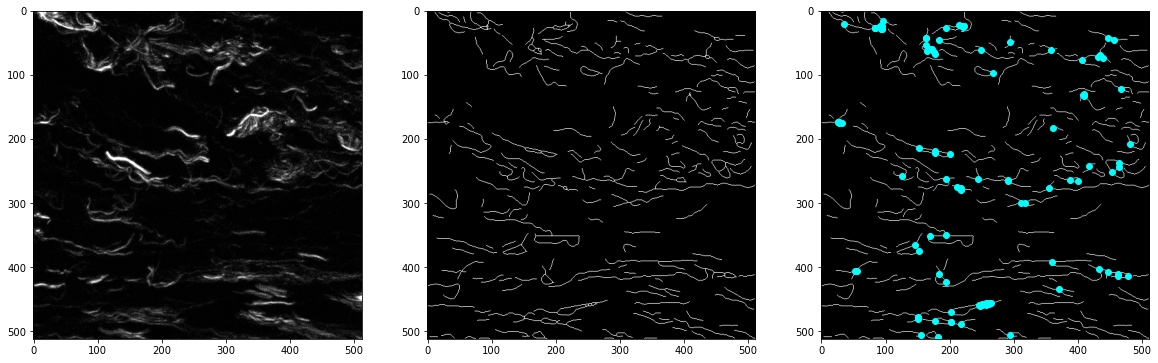

In [4]:
# create centerline from masks
centerline = CenterLine(centerline_image=io.imread("example_centerline.png"), associate_image=io.imread("example_image.tif"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()

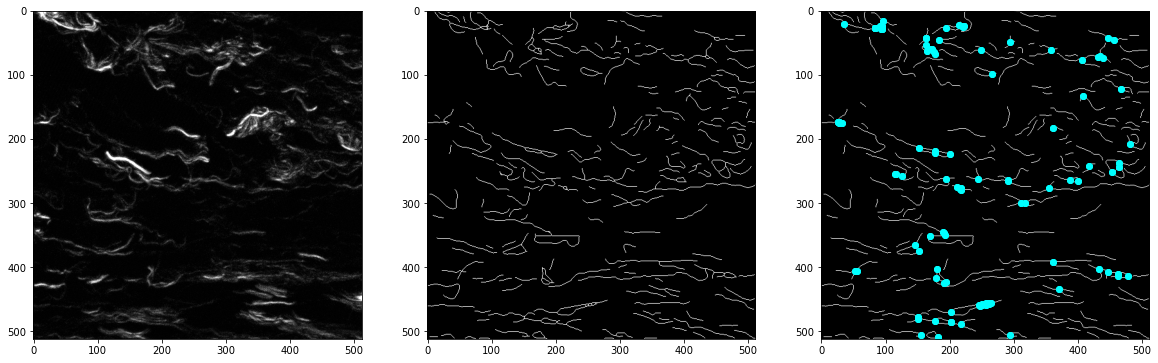

In [5]:
# create centerline from dataframe
centerline = CenterLine(dataframe=pd.read_csv("example_annotations.csv", index_col=0), associate_image=io.imread("example_image.tif"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()

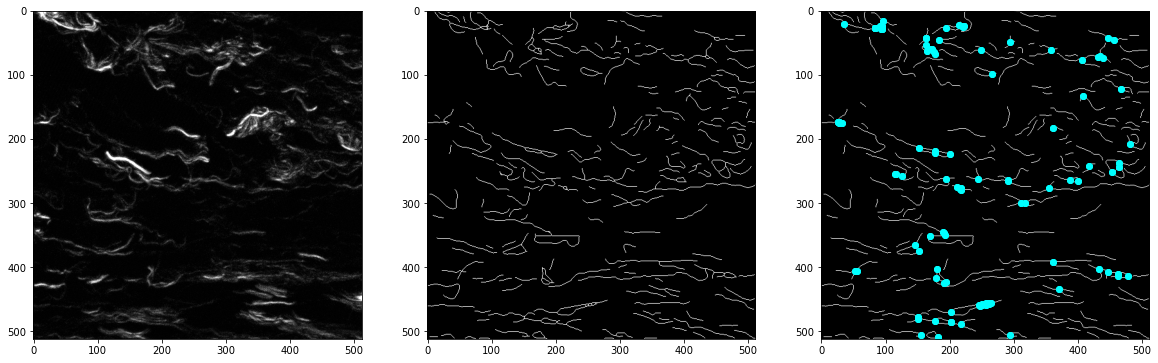

In [6]:
# create centerline from line_dict object
line_dict = centerline.line_dict
centerline = CenterLine(line_dict=line_dict, associate_image=io.imread("example_image.tif"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()

In [7]:
### compute centerline features, example using centerline_image
centerline = CenterLine(centerline_image=io.imread("example_centerline.png"), associate_image=io.imread("example_image.tif")) # joints are NOT broken by default
centerline.compute_fiber_feats() 
print(centerline.feats)

{'cir_mean': 0.08977087549280571, 'cir_var': 0.21514772248140548, 'len_mean': 32.47154471544715, 'len_var': 28.177233848799847, 'waviness': 0.1733660681891675, 'intensity': 8073, 'density': array([[0.00000000e+00, 1.24918532e-05, 1.45093057e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.41551241e-05, 1.47353429e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.24918532e-05, 1.24015687e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.23493735e-02, 7.69430059e-02, 1.50921195e-01, ...,
        5.43406339e-01, 5.06423127e-01, 4.71139026e-01],
       [2.30717563e-02, 5.51314503e-02, 1.08611903e-01, ...,
        7.11445148e-01, 6.97601591e-01, 6.74055600e-01],
       [1.31286026e-02, 3.16002612e-02, 6.26761920e-02, ...,
        8.34643959e-01, 8.50325510e-01, 8.44492241e-01]])}


In [8]:
### compute centerline features, example using dataframe
centerline = CenterLine(dataframe=pd.read_csv("example_annotations.csv", index_col=0), associate_image=io.imread("example_image.tif"))
centerline.compute_fiber_feats() 
print(centerline.feats)

{'cir_mean': 0.09355125796618147, 'cir_var': 0.21297570230003723, 'len_mean': 32.12903225806452, 'len_var': 28.67925172853429, 'waviness': 0.17059923456349105, 'intensity': 8077, 'density': array([[0.00000000e+00, 1.24918532e-05, 1.45093057e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.41551241e-05, 1.47353429e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.24918532e-05, 1.24015687e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.23493735e-02, 7.69430059e-02, 1.50921195e-01, ...,
        5.43406339e-01, 5.06423127e-01, 4.71139026e-01],
       [2.30717563e-02, 5.51314503e-02, 1.08611903e-01, ...,
        7.11445148e-01, 6.97601591e-01, 6.74055600e-01],
       [1.31286026e-02, 3.16002612e-02, 6.26761920e-02, ...,
        8.34643959e-01, 8.50325510e-01, 8.44492241e-01]])}


In [261]:
### currently, breaking joints + linking fiber is lossy, safest way is to work with all masks

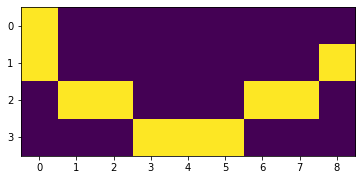

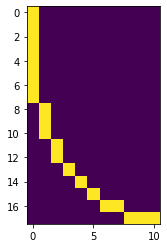

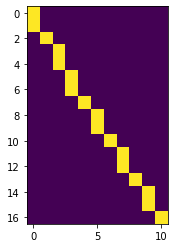

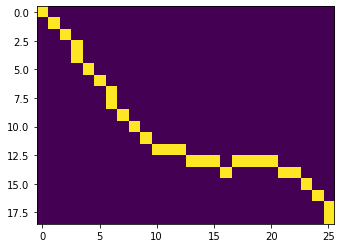

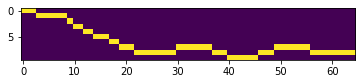

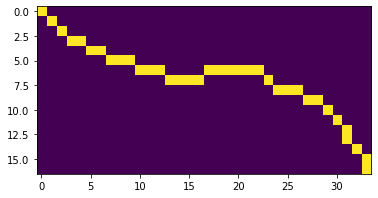

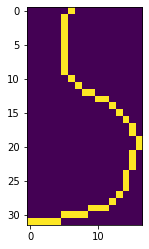

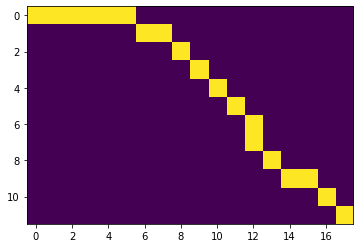

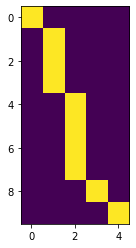

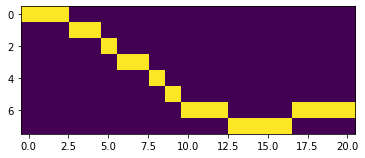

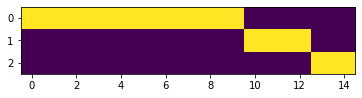

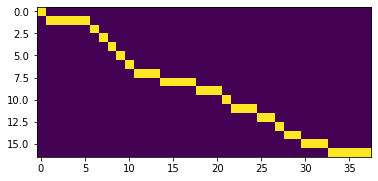

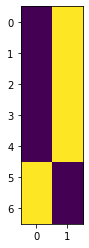

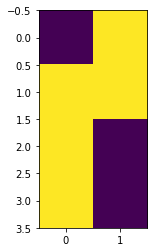

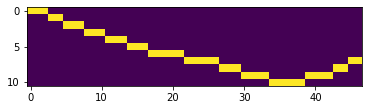

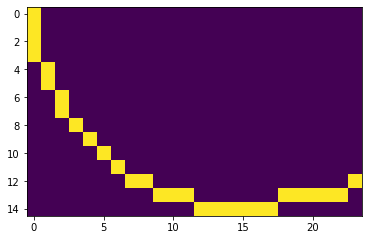

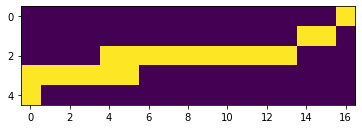

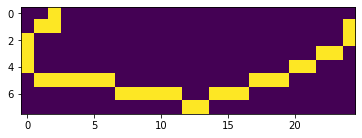

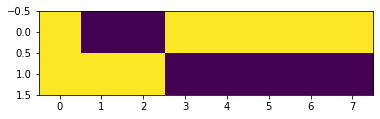

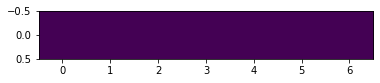

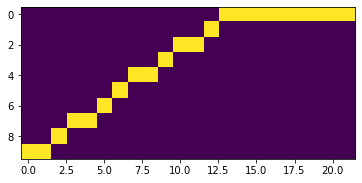

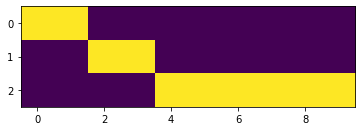

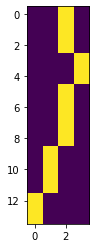

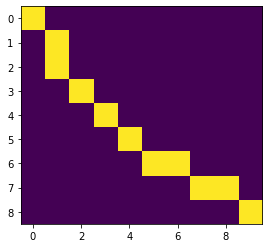

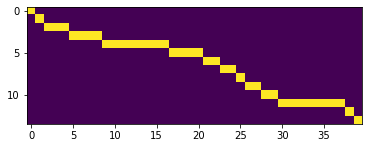

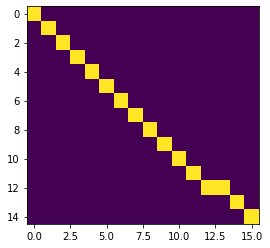

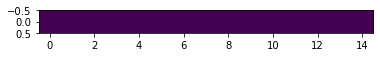

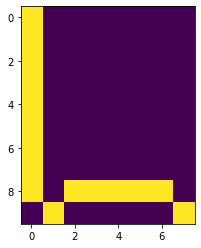

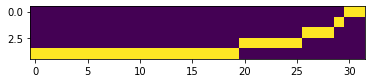

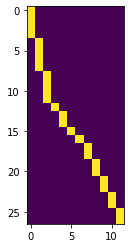

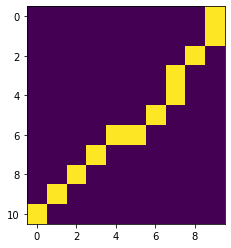

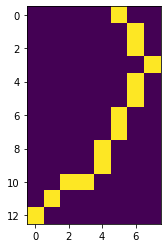

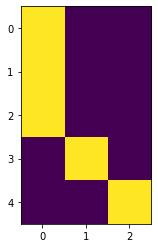

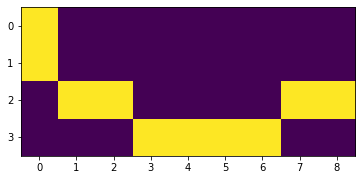

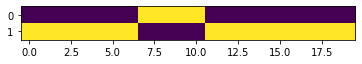

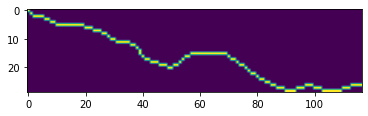

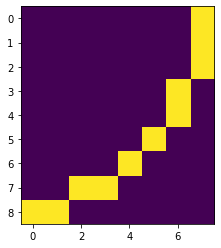

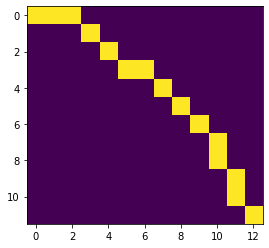

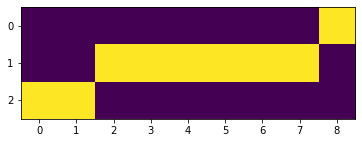

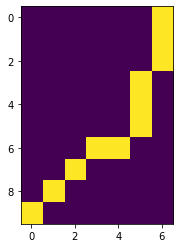

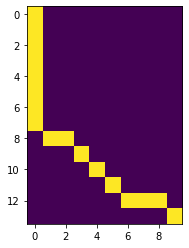

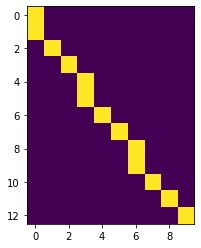

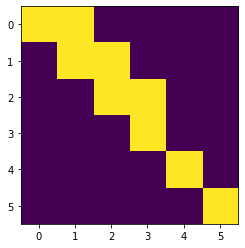

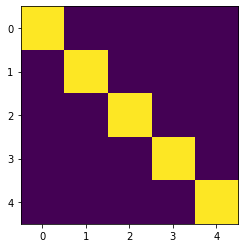

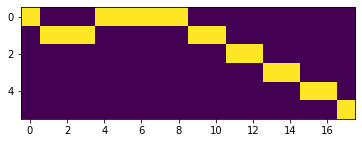

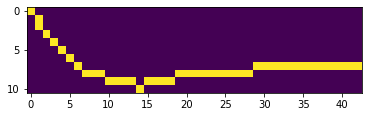

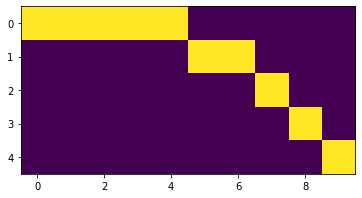

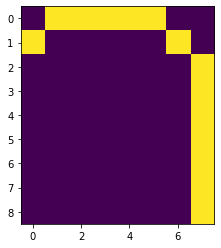

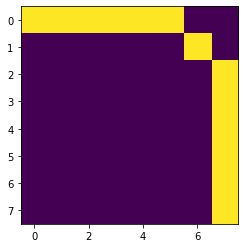

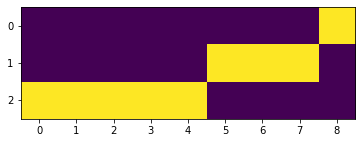

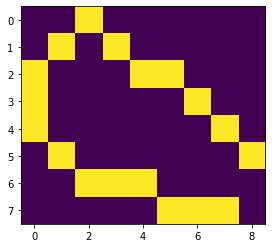

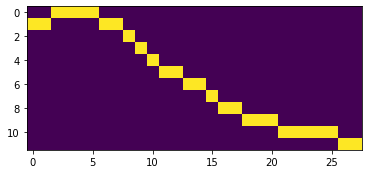

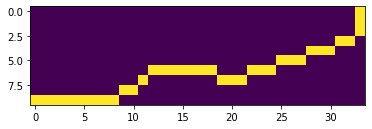

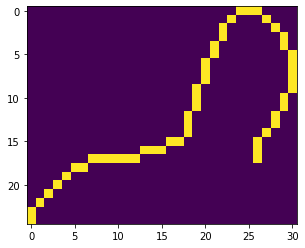

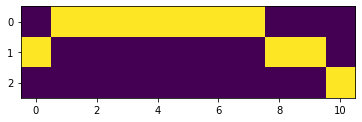

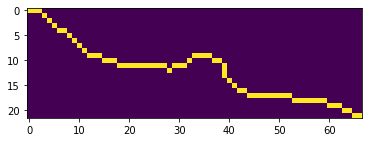

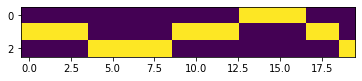

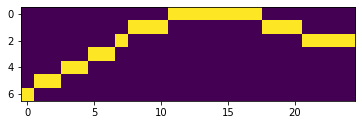

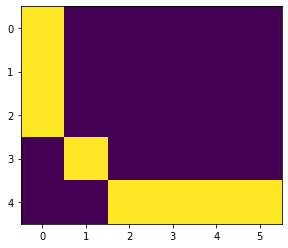

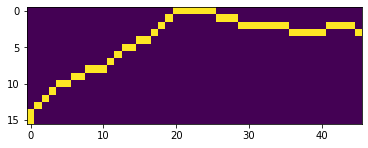

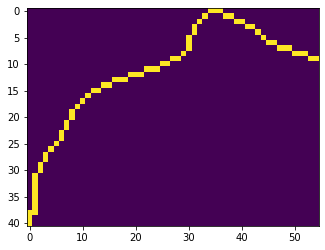

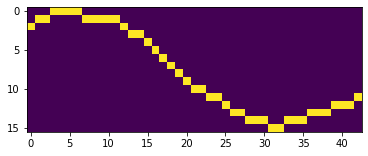

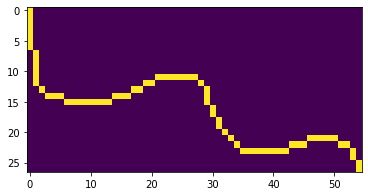

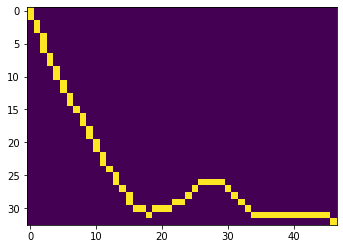

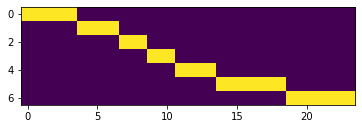

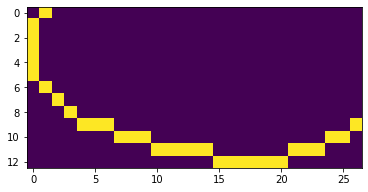

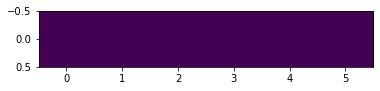

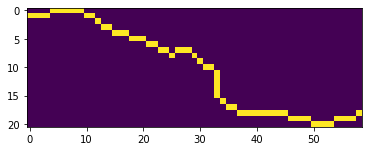

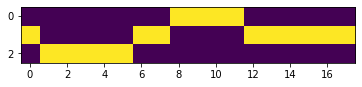

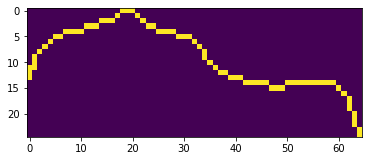

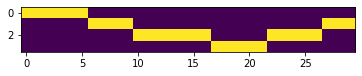

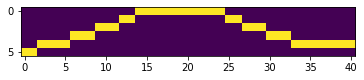

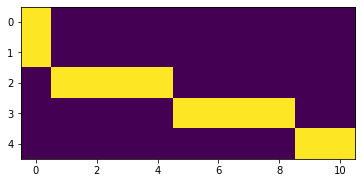

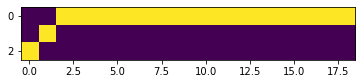

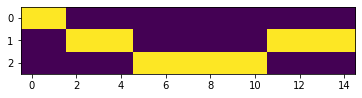

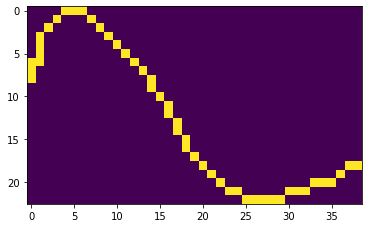

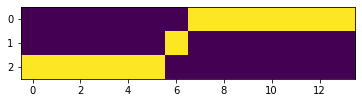

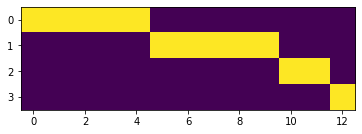

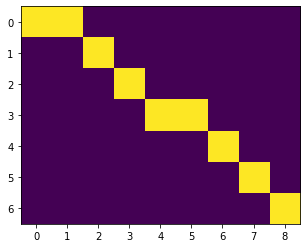

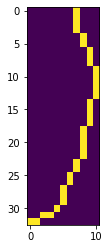

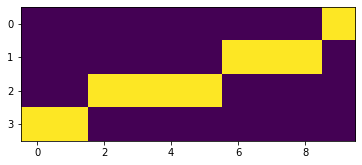

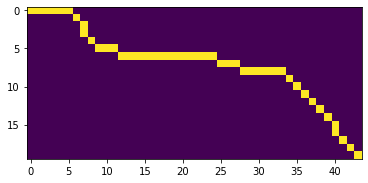

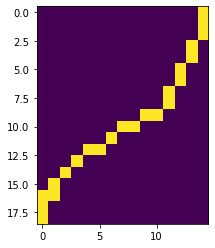

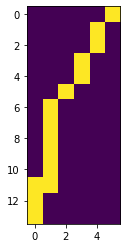

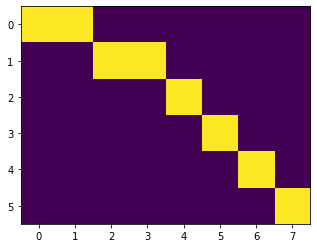

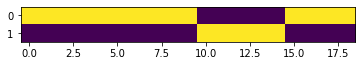

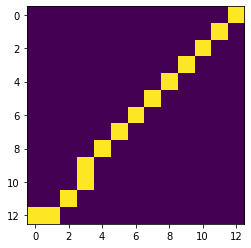

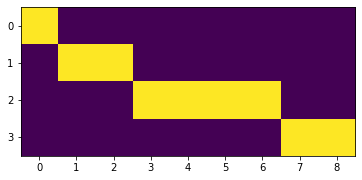

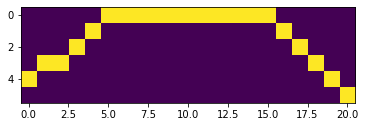

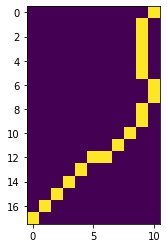

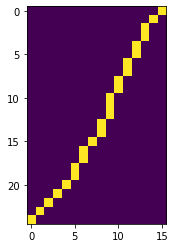

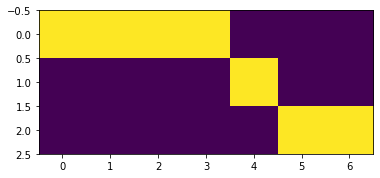

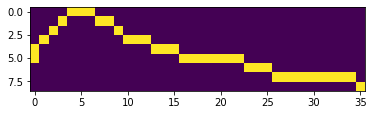

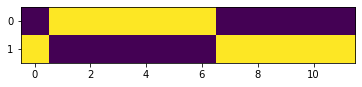

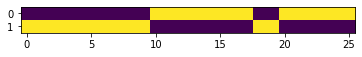

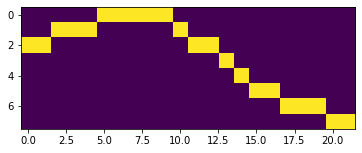

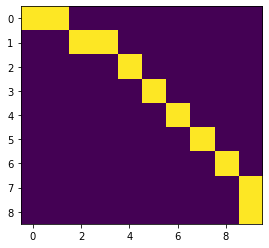

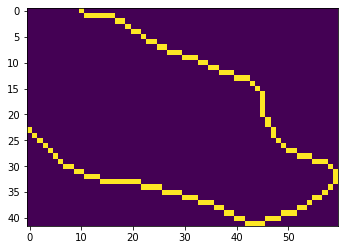

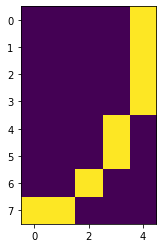

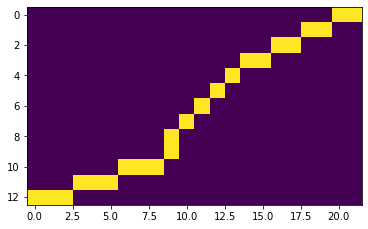

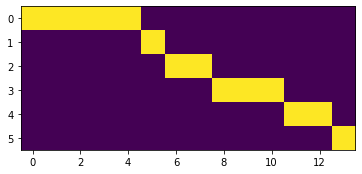

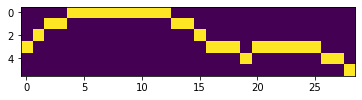

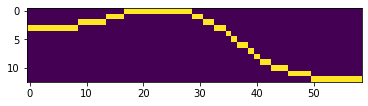

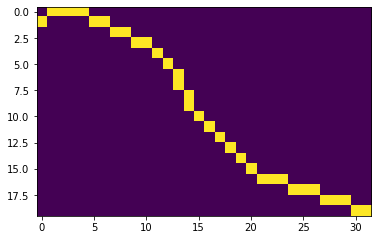

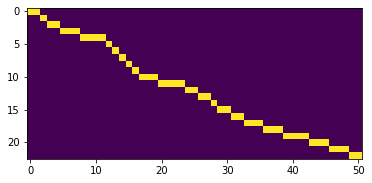

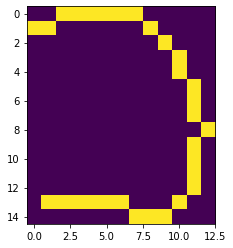

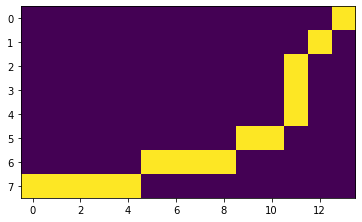

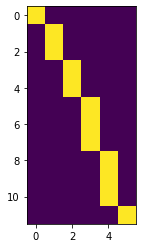

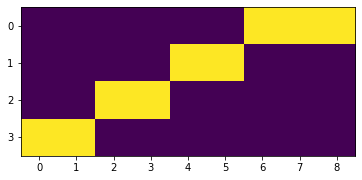

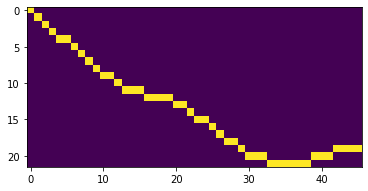

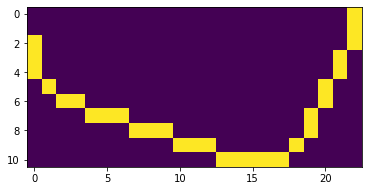

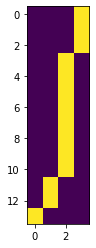

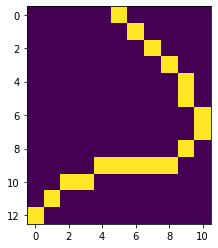

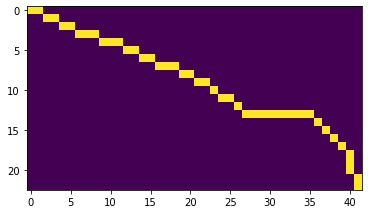

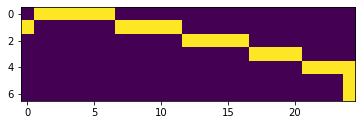

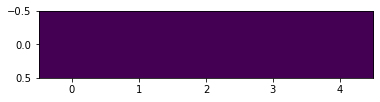

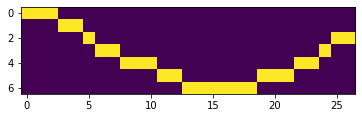

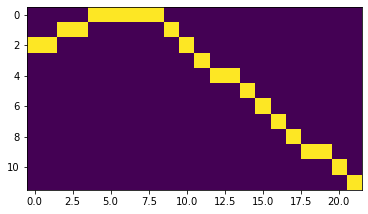

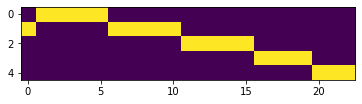

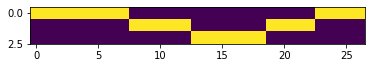

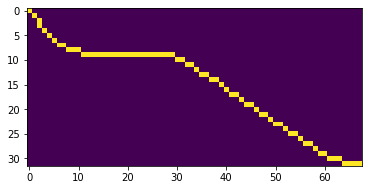

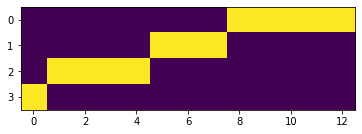

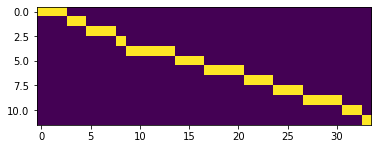

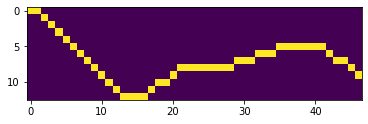

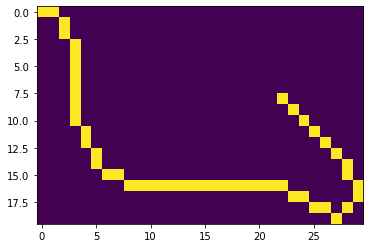

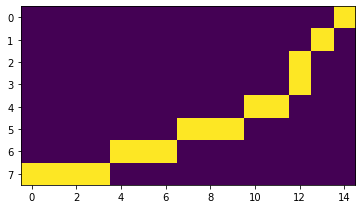

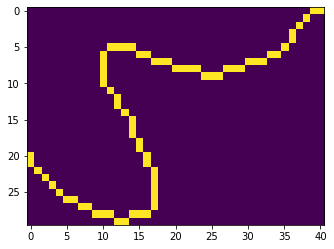

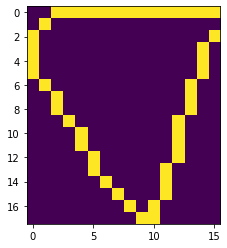

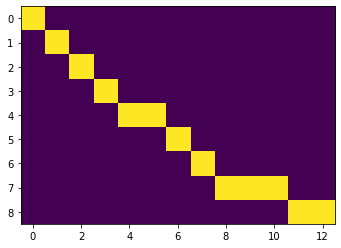

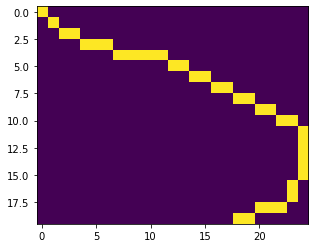

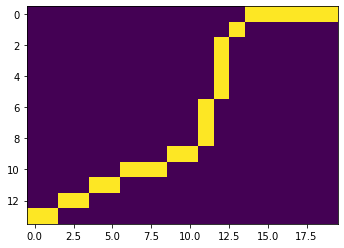

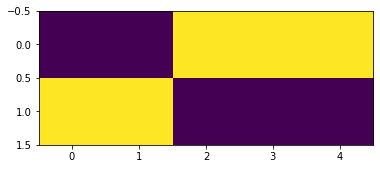

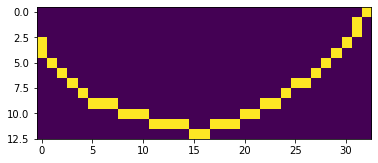

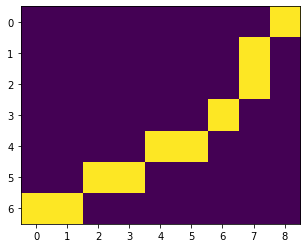

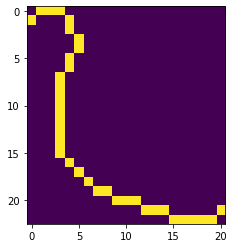

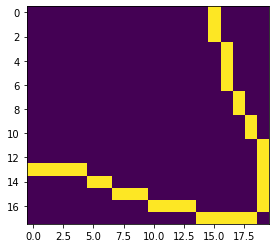

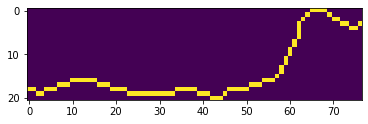

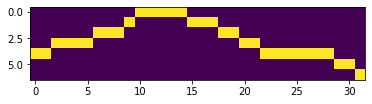

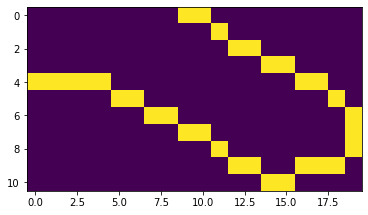

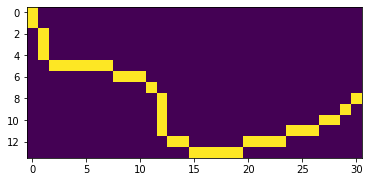

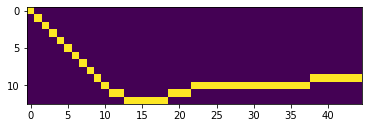

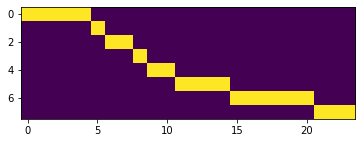

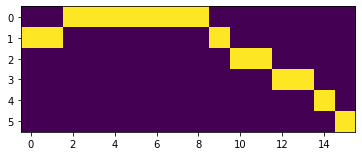

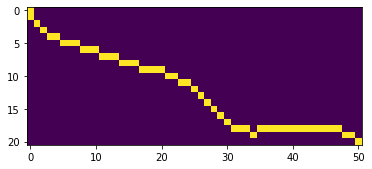

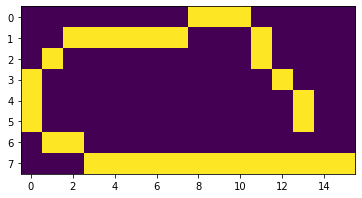

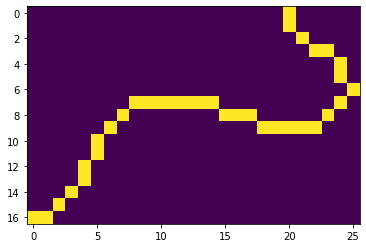

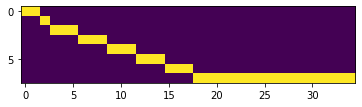

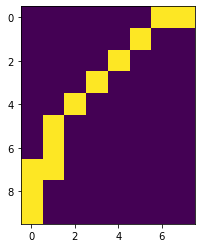

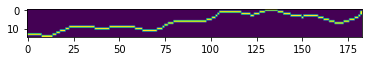

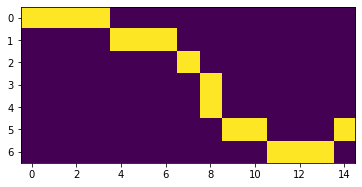

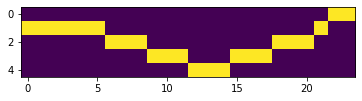

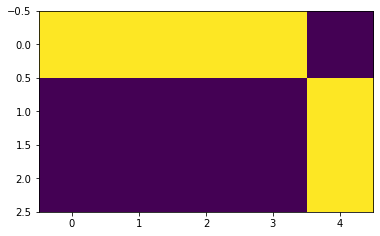

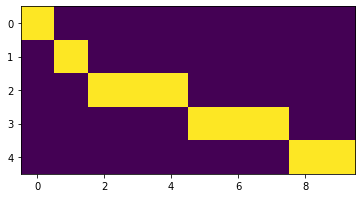

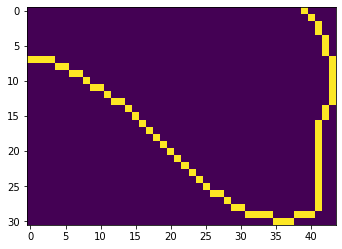

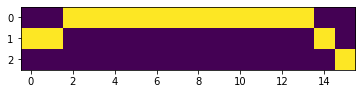

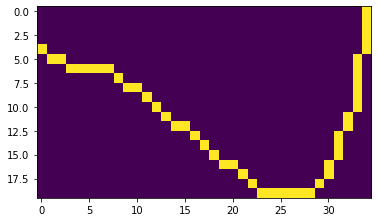

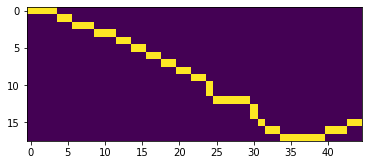

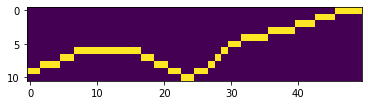

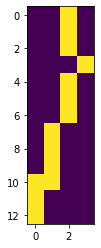

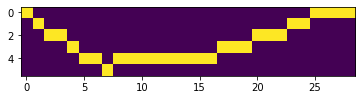

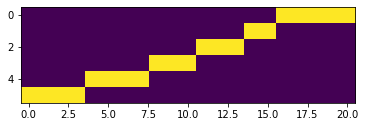

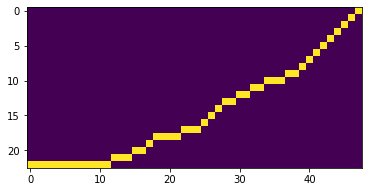

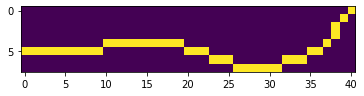

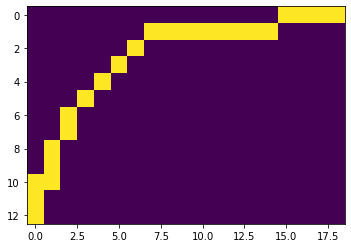

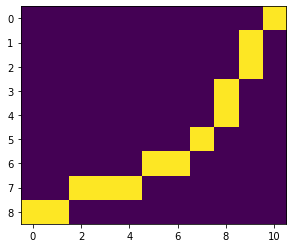

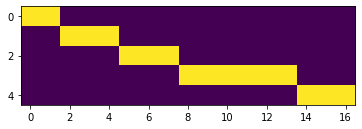

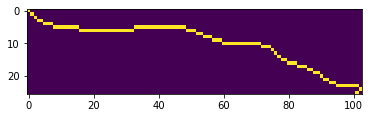

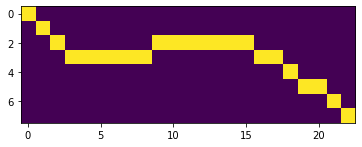

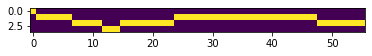

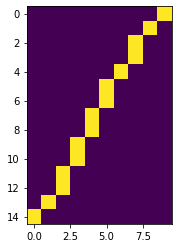

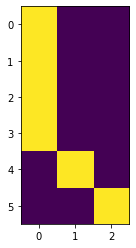

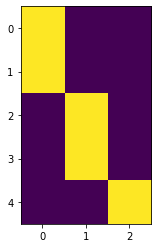

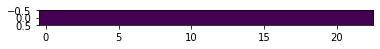

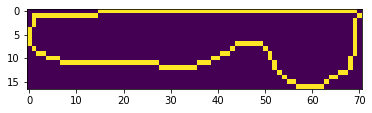

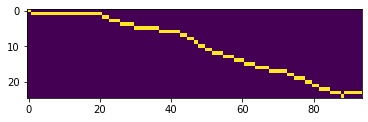

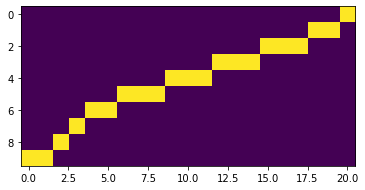

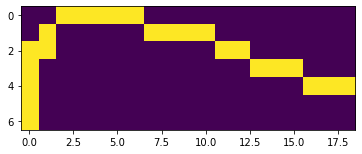

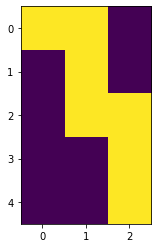

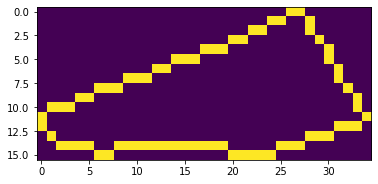

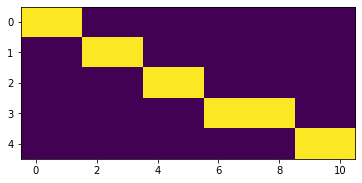

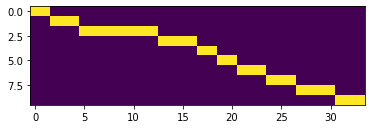

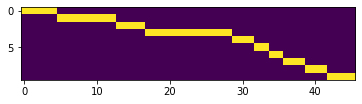

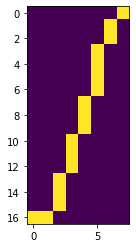

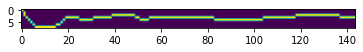

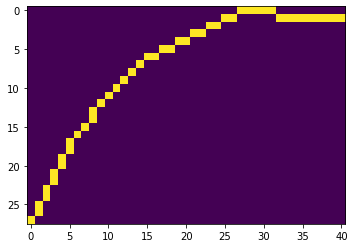

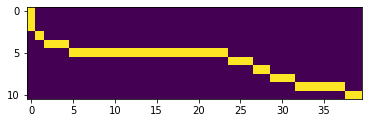

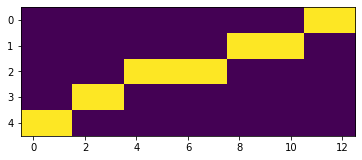

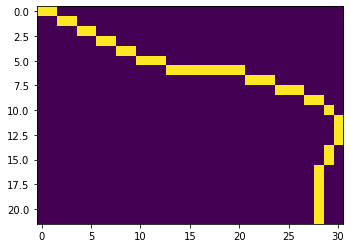

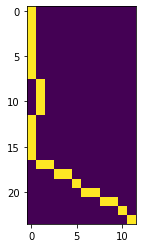

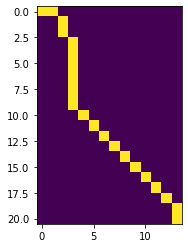

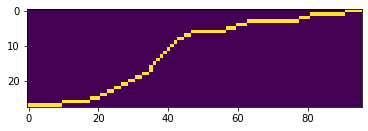

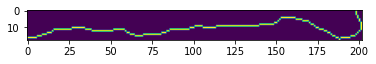

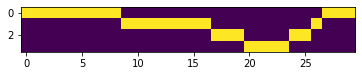

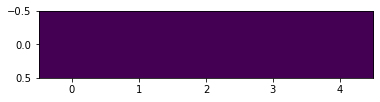

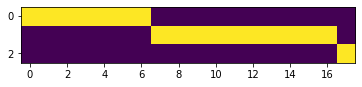

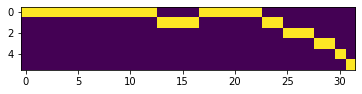

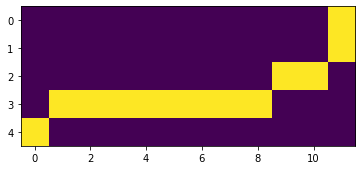

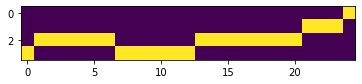

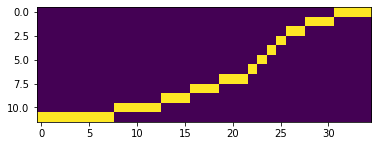

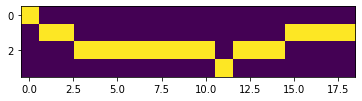

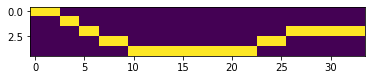

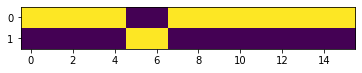

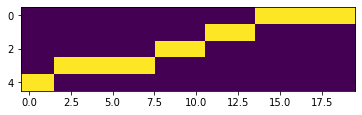

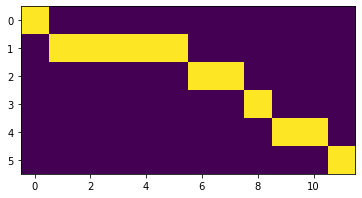

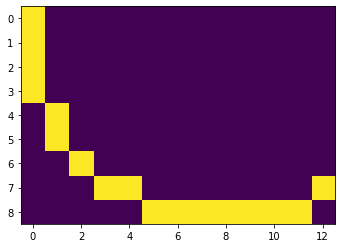

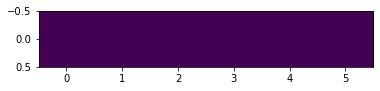

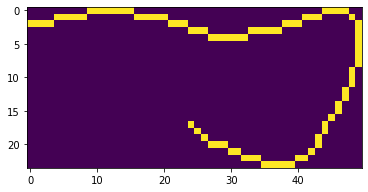

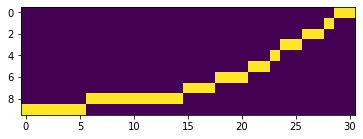

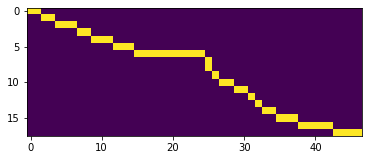

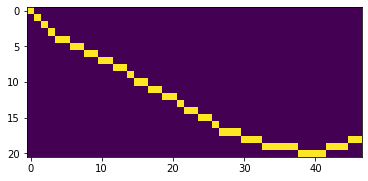

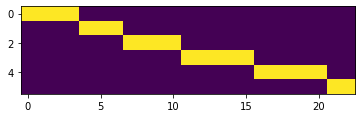

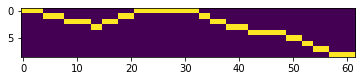

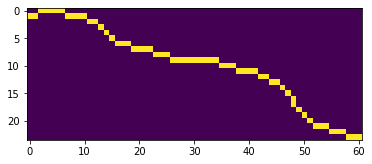

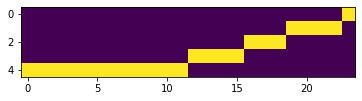

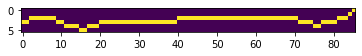

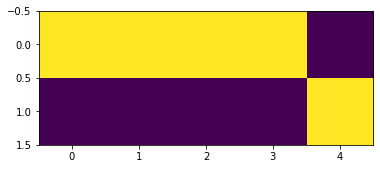

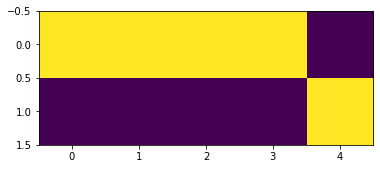

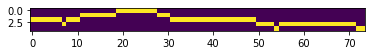

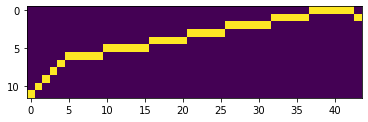

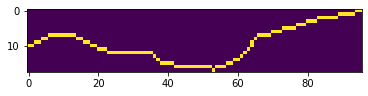

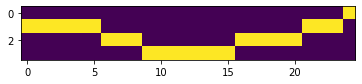

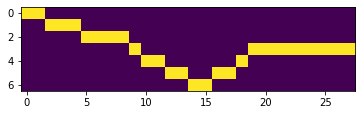

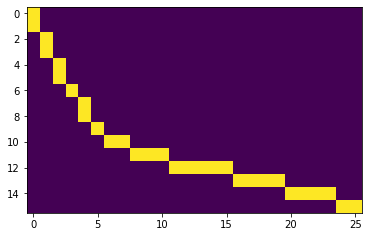

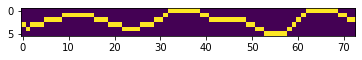

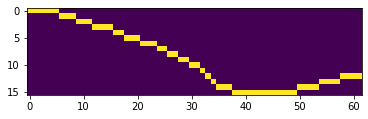

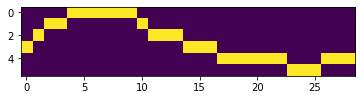

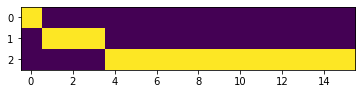

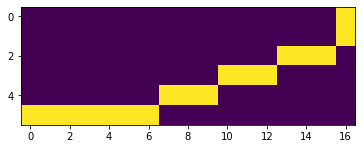

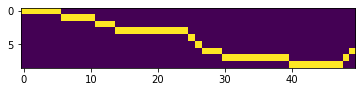

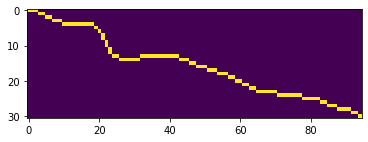

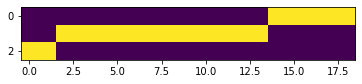

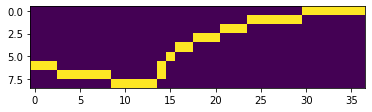

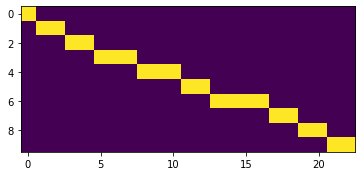

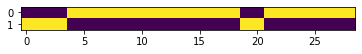

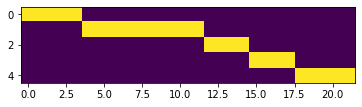

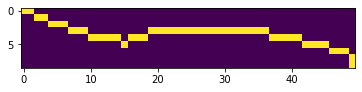

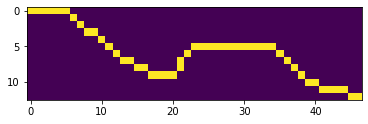

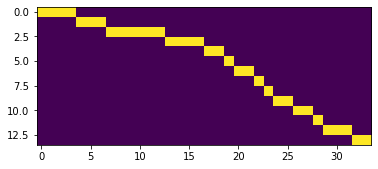

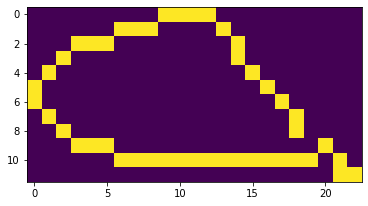

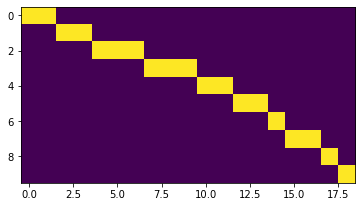

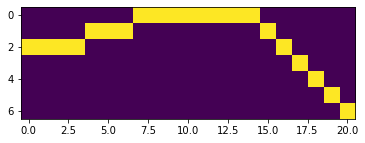

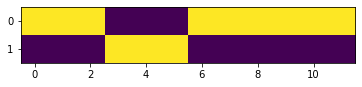

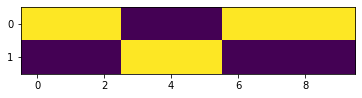

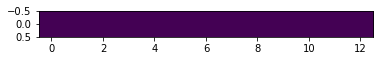

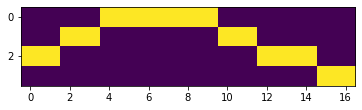

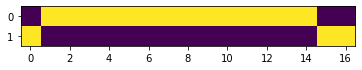

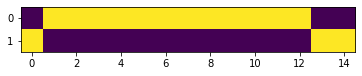

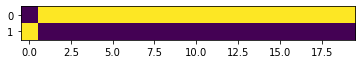

In [262]:
for region in centerline.regions:
    plt.imshow(region.image)
    plt.show()

### Measure the similarity of two centerline (masks)

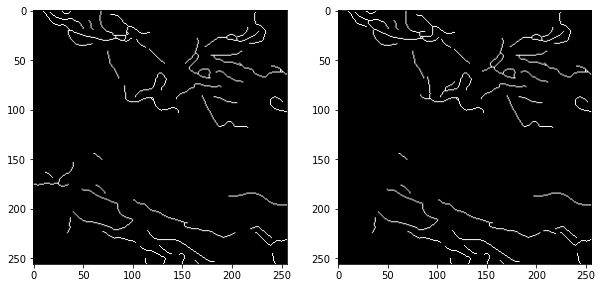

In [14]:
### any two centerline masks
image_1 = io.imread('Michael.tif')
image_2 = io.imread('Bin.tif')
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image_1, cmap='gray')
ax[1].imshow(image_2, cmap='gray')

0.9228023152549197


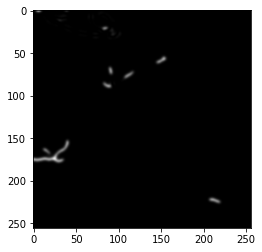

In [17]:
### Pixel-level metrics, soft IoU
ratio, U, I = iou(smooth_mask(image_1), smooth_mask(image_2), soft=True)
plt.imshow(U-I, cmap='gray')
print(np.sum(I)/np.sum(U))

In [ ]:
### cosine similarity of the features, maybe need to normalize each feature throughout the testing set